In [1]:
# 1 Initialization
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.colors as c
from pylatex import Document, Section, Subsection, Tabular, Math, TikZ, Axis, \
    Plot, Figure, Matrix, Alignat
from pylatex.utils import italic
import os
import mpmath
import sympy as sp
from astropy.io import fits
from datetime import datetime
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from IPython.display import clear_output

In [2]:
# 2 Important Parameters
observingLatitudeDegrees = 40 # Observing latitude - Default : 35
viewLength = 3e17 # Length of the display box - Default : 6e17
distanceLY = 8000 # Distance to the lebula in light years 
resolution = 500 # Number of pixels of one side of the display - Default : 200
distance_steps = 3000 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 1800 # Number of angle steps in the optical depth center array - Default : 1800
absorptionSteps_center = 10 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 10
absorptionSteps = 5 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5
starRadius = 7e11 # Radius of the central star, used to determine the flux arriving at earth

In [3]:
# 3 Nebula Shape Parameters
# Basic shape properties of the nebula
Rin = 1e16 # Inner cavity radius - Default : 1e16
power = 2 # Density inverse relation to radius - Default : 2
density_enhancement = 20 # Density enhancement factor in lobe edge - Default : 7
ansa_density = 4 # Density enhancement factor in ansa - Default : 4
edge_thickness = 0.12
focus = 5e15
directrix = -1.55e16-1.2e16
eccentricity = 0.78
cutoff_distance = 7e16
outer_slope = 0.3

In [4]:
# 4 Nebula Content Parameters
# Mass properties of the nebula
# Luminosity_Solar_Luminosity = 1 # Luminosity of the central star in Solar Luminosity
# Luminosity = Luminosity_Solar_Luminosity*3.83e26 # Luminosity of the central star in Watts
Mdot_Solar_Mass = 1e-5 # Mass loss rate of all molecules in solar masses - Default : 1e-5
Mdot = Mdot_Solar_Mass*2e33/(365*24*60*60) # Mass loss rate of all molecules in g/seconds
particle_radius = 1e-5 # cm - Default : 1e-5 / smaller
wavelength = 5.83e-5 # cm - Default : 5e-5
albedo = 0.5
scattering_effective_crosssection = (np.pi*particle_radius**2)*2*np.pi*(particle_radius/(wavelength)) # Per grain per cm^2
dust_to_gas = 1/200 # Dust to gas ratio - Default : 1/200
grain_mass = 1.3e-14 # Mass of the individual grain in grams - Default : 1.3e-14
asymmetry_constant = 0.5 # The scattering asymmetry constant - Default : 0.5

In [5]:
# 5 Pre-compute Important Numbers
observingLatitude = np.pi*(observingLatitudeDegrees/180) # The latitude the observer is currently at in radians
sin = np.sin(observingLatitude) # precompute the trigs of the observer
cos = np.cos(observingLatitude)
viewSize = viewLength/2 # Half the size of the picture
angularSize = viewSize/(distanceLY/2.18e-13)
FD = focus - directrix
center = focus + FD*eccentricity**2/(1-eccentricity**2)
focus_2 = center - (center - focus)*(1 - edge_thickness)
directrix_2 = center - (center - directrix)*(1 - edge_thickness)

In [6]:
# 6 Logistic functions
def norm(x):
    return np.sqrt(x[0]**2+x[1]**2+x[2]**2)
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x,y,z]))

def vector_angle(v1,v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1==0 or norm2==0:
        return 0
    else:
        factor = np.dot(v1,v2)/(norm1*norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return np.pi
        else:
            return np.arccos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur=np.sin(r[1])
    return np.array([r[0]*sin_cur*np.cos(r[2]),r[0]*sin_cur*np.sin(r[2]),r[0]*np.cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = np.sqrt(x[0]**2+x[1]**2+x[2]**2) # pre compute the norm of the vector
    if norm==0:
        return np.array([0,0,0])
    elif x[0]==0:
        return np.array([norm,np.arccos(x[2]/norm),np.pi/2])
    else:
        return np.array([norm,np.arccos(x[2]/norm),np.arctan(x[1]/x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [7]:
# 7 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1/(4*np.pi)*(1 - asymmetry_constant**2)/((1 + asymmetry_constant**2 - 2*asymmetry_constant*np.cos(angle))**(3/2))

In [8]:
x, y = sp.symbols('x y')
eq1 = sp.Eq(((cutoff_distance**2+focus**2-2*cutoff_distance*focus*(x/cutoff_distance))**(1/2)/(cutoff_distance*(x/cutoff_distance) - directrix)) - eccentricity, 0)
eq2 = sp.Eq(x**2 + y**2 - cutoff_distance**2, 0)
sol = sp.solve((eq1, eq2),(x, y))
x_cut = np.abs(sol[1][0])
y_cut = np.abs(sol[1][1])

x, y = sp.symbols('x y')
eq1 = sp.Eq(((cutoff_distance**2+focus_2**2-2*cutoff_distance*focus_2*(x/cutoff_distance))**(1/2)/(cutoff_distance*(x/cutoff_distance) - directrix_2)) - eccentricity, 0)
eq2 = sp.Eq(x**2 + y**2 - cutoff_distance**2, 0)
sol = sp.solve((eq1, eq2),(x, y))
x_cut_2 = np.abs(sol[1][0])
y_cut_2 = np.abs(sol[1][1])

y_intercept = y_cut + outer_slope * x_cut
y_intercept_2 = y_cut_2 + outer_slope * x_cut_2

In [9]:
# 8 Detailed Shape of the Nebula
def lobe(sin_lat, distance): #both must be positive absolute values
    if distance < cutoff_distance:
        pf = np.sqrt(distance ** 2 + focus ** 2 - 2 * distance * focus * sin_lat) # law of cosines
        pd = distance * sin_lat - directrix
        if np.abs(pf / pd) < eccentricity:
            pf_2 = np.sqrt(distance ** 2 + focus_2 ** 2 - 2 * distance * focus_2 * sin_lat) # law of cosines
            pd_2 = distance * sin_lat - directrix_2
            if np.abs(pf_2 / pd_2) < eccentricity:
                return 1
            return 2
        else:
            return 0
    else:
        x = distance * sin_lat
        y = distance * (1 - sin_lat ** 2) ** (1 / 2)
        if y <= y_intercept - x * outer_slope:
            if y <= y_intercept_2 - x * outer_slope:
                return 1
            return 2
        
def ansa(sin_lat, distance):
    pf_ansa = np.sqrt(distance ** 2 + 7.5e16 ** 2 - 2 * distance * 7.5e16 * sin_lat) # law of cosines
    pd_ansa = distance * sin_lat - 6e16
    if np.abs(pf_ansa / pd_ansa) < 0.5:
        return 1
    else:
        return 0

def density(latitude, distance):
    if distance < Rin / 2:
        return 0
    sin_lat = np.abs(np.sin(latitude))
    lat = np.abs(latitude / np.pi * 2)
    if lobe(sin_lat, distance) == 1:
        if ansa(sin_lat, distance) == 1:
            velocity = 5e6
            dr_cur = 1e16
            R_cur = 1e17
        else:
            velocity = 2e7
            dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
            if lat >= 85 / 90:
                R_cur = 1e17 # 1.87e+17 # cutoff radius, unit in cm
            else:
                R_cur = 1.6e17 # 1.87e+17 # cutoff radius, unit in cm
    elif lobe(sin_lat, distance) == 2:
        velocity = 2e7 / density_enhancement
        dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
        if lat >= 85 / 90:
            velocity = 2e7
            R_cur = 1e17 # 1.87e17 # cutoff radius, unit in cm
        else:
            R_cur = 1.87e17 # cutoff radius, unit in cm
    else: # Disk
        velocity = 5e5 + 1e6 * np.abs(sin_lat)**2
        dr_cur = 3e15
        R_cur = 6e16
        
    cutoff_outer = 0.5 * (1 - np.tanh((distance -  R_cur) / dr_cur)) + 0.005
    cutoff_inner = 0.5 * (1 - np.tanh((Rin - distance) / (Rin / 10)))
    
    return (dust_to_gas * Mdot / grain_mass) * (cutoff_outer * cutoff_inner) / (4 * np.pi * (distance ** power) * velocity)
def density_cartesian(x):
    spherical = cartesian_to_spherical(x) # x in spherical coordinates
    return density(np.pi / 2 - spherical[1], spherical[0])

In [10]:
# 9 Density Display Function
@np.vectorize
def density_map(x, y):
    return density_cartesian(np.array([0, y, -x])) ** (1 / float(5))
# Density display, density scales by the power of 1/5

<ipython-input-9-e25a53b352b4>:25: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(pf_ansa / pd_ansa) < 0.5:


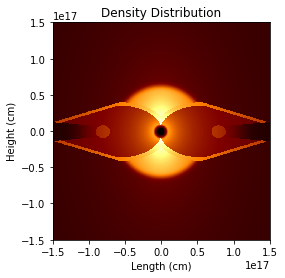

In [11]:
# 10 Density Display
side = np.linspace(-viewSize, viewSize, 2 * resolution + 1)
x, y = np.meshgrid(side, side)
Value = density_map(x, y)
plt.xlabel("Length (cm)")
plt.ylabel("Height (cm)")
plt.title("Density Distribution")
plt.pcolormesh(x, y, Value, cmap = 'afmhot', shading = 'auto')
plt.gca().set_aspect('equal')

total_mass = 0.0
x = -viewSize
y = -viewSize
z = -viewSize
while x <= viewSize:
    y = -viewSize
    while y <= viewSize:
        z = -viewSize
        while z <= viewSize:
            total_mass = total_mass + density_cartesian(np.array([x,y,z]))
            z += 1e16
        y += 1e16
    x += 1e16
total_mass = total_mass*48*1e48*grain_mass
print(total_mass)

In [12]:
# 11 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x,y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x,y in cm 
    return int(int(((x/viewSize)+1)*(resolution/2))+int((y/viewSize)*(resolution/2))*(resolution+1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i%(resolution+1))/(resolution/2)-1)*viewSize
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i/(resolution+1))/(resolution/2))*viewSize

In [13]:
# 12 Define Spherical Optical Depth Integration Function
def optical_depth_center_progression(latitude,distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density(latitude,distance+i*(viewSize/(distance_steps*absorptionSteps_center)))
        sum += add # add the non constant density
        i += 1/absorptionSteps_center
    sum = scattering_effective_crosssection*sum*(2*viewSize/(distance_steps*absorptionSteps_center)) # now multiply the constants of the integrand
    return sum/albedo # return the result

In [14]:
def optical_depth_center_real(latitude,distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 1 # iterator
    while i <= 300:
        add = density(latitude,i*(distance/300))
        sum += add # add the non constant density
        i += 1
    sum = scattering_effective_crosssection*sum/300*distance # now multiply the constants of the integrand
    return sum/albedo # return the result

In [15]:
# 13 Spherical Optical Depth Array
# Define the spherical optical depth array
# i from 0 to distance_steps, represents distance from 0 to 2*viewSize
# j from 0 to pi/2, represents the latitude
i, j = distance_steps+1, angle_steps+1
optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

In [16]:
# 14 Computing The Spherical Optical Depth Array
for i in range(0,angle_steps):
    for j in range(0,distance_steps):
        # For each angle, accumulatively compute the optical depth
        add = optical_depth_center_progression(i*np.pi/(2*angle_steps),j*(2*viewSize/distance_steps))
        optical_depth_center_array[i][j] = optical_depth_center_array[i][j-1] + add

In [17]:
import csv
np.savetxt("Arrays/odc.csv", optical_depth_center_array, delimiter=",")

In [18]:
# 15 Define Cubical Optical Depth Integration Function
n = 2*viewSize/resolution
def optical_depth_progression(x1,x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1+i*(x2-x1))
        sum += add # add the non constant density
        i += 1/absorptionSteps
    sum = scattering_effective_crosssection*sum*n/absorptionSteps # now multiply the constants of the integrand
    return sum/albedo # return the result

In [19]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution+1, (resolution+1)*(int(resolution/2)+1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [20]:
# 17 Computing The Cubical Optical Depth Array
r = (resolution+1)*(int(resolution/2)+1)-1
for i in range(0,r):
    for j in range(0,resolution):
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        add = optical_depth_progression(np.array([x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin]),np.array([x*sin+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*sin]))
        optical_depth_array[i][j] = optical_depth_array[i][j-1] + add

In [21]:
np.savetxt("Arrays/od.csv", optical_depth_array, delimiter=",")

In [22]:
optical_depth_center_array = np.loadtxt("Arrays/odc.csv",skiprows=0,delimiter = ',')
optical_depth_array = np.loadtxt("Arrays/od.csv",skiprows=0,delimiter = ',')

In [23]:
# 18 Defining the Optical Intensity Function
asymmetry_constant = 0.5 # This can change with each recompute, without altering the array, mainly changing front/back ratio
scale_factor = 300 # The post-compute multiplier applied to the density/optical depth array
@np.vectorize
def intensity(x,y):
    sum = 0.0
    i = coord_to_index(x,y)
    for j in range(0,resolution):
        cur = np.array([float(x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos),float(y),float(-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin)]) # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) # spherical of current point, to find the optical depth center
        o_d_center = scale_factor*optical_depth_center_array[np.abs(int((angle_steps/90)*(90-(180*spherical[1]/np.pi))))][int(spherical[0]/(2*viewSize)*distance_steps)]
        o_d = scale_factor*optical_depth_array[i][j]
        add = (1/(4*np.pi*((spherical[0])**2)))*mpmath.exp(-o_d)*mpmath.exp(-o_d_center)*scale_factor*scattering_effective_crosssection*density(np.pi/2-spherical[1],spherical[0])*phase_function(vector_angle(np.array([cos,0,sin]),cur))*((2*angularSize*4.848e-6*distanceLY*9.461e17)/resolution)**3/(((2*angularSize*4.848e-6*distanceLY*9.461e17)/resolution/7e10)**2)
        if x==0 and y==0 and j == resolution/2:
            add = mpmath.exp(-scale_factor*optical_depth_array[coord_to_index(0,0)][int(j)])
        sum += add
    return sum

side = np.linspace(-viewSize,0,int(resolution/2)+1)
sideY = np.linspace(0,0,1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
scale_factor = 65
scale_factor_step = scale_factor/2
while(True):
    Value = intensity(x,y)
    a = np.nanmax(Value[0][0:int(resolution/2)])
    b = intensity(0,0)
    print(b/a)
    print(b)
    print(a)
    print(scale_factor)
    if np.abs((b/a)-resolution**2/20000)<=0.1:
        break;
    if b/a>=resolution**2/20000:
        scale_factor = scale_factor + scale_factor_step
        scale_factor_step = scale_factor_step/2
    if b/a<resolution**2/20000:
        scale_factor = scale_factor - scale_factor_step
        scale_factor_step = scale_factor_step/2

side = np.linspace(-viewSize,viewSize,resolution+1)
sideY = np.linspace(0,0,1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
asymmetry_constant = 0.5
asymmetry_constant_step = asymmetry_constant/2
while(True):
    Value = intensity(x,y)
    a = np.nanmax(Value[0][int(resolution/2)+2:resolution+1])
    b = np.nanmax(Value[0][0:int(resolution/2)])
    if np.abs((b/a)-10)<=1:
        break;
    if b/a>=10:
        asymmetry_constant = asymmetry_constant - asymmetry_constant_step
        asymmetry_constant_step = asymmetry_constant_step/2
    if b/a<10:
        asymmetry_constant = asymmetry_constant + asymmetry_constant_step
        asymmetry_constant_step = asymmetry_constant_step/2

In [24]:
# 19 Computing The Top Half Intensity Array
side = np.linspace(-viewSize,viewSize,resolution+1)
sideY = np.linspace(0,viewSize,int(resolution/2)+1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
Value = intensity(x,y) # compute half of the intensity map

In [25]:
# 20 Generating Full Image
@np.vectorize
def findValue(x,y):
    cur_x = int((x/(angularSize)+1)*resolution/2)
    cur_y = round(y*resolution/angularSize/2)
    if y > 0:
        return float(Value[cur_y][cur_x])
    elif y==0:
        return float(Value[0][cur_x])
    else:
        return float(Value[-cur_y][cur_x])

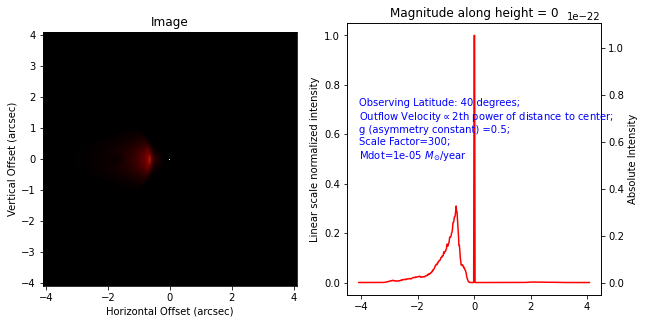

In [26]:
# 21 Plots
side_angular = np.linspace(-angularSize,angularSize,resolution+1)
X,Y = np.meshgrid(side_angular,side_angular)
np.seterr(divide='ignore')
fullValues = findValue(X,Y)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121, aspect=1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X,Y,fullValues,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')
# plt.annotate('*', xy=(-0.080,-0.205), color = 'green', size = 20, label = 'star')
#ax.scatter(np.array([0]),np.array([0]),color = 'green', marker = 'x')
# fig, ax = plt.subplots()
# CS = ax.contour(X,Y,logFullValues)
# plt.gca().set_aspet('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize,angularSize,resolution+1)
y_array = fullValues[int(resolution/2)]
normalizedYArray = y_array/np.max(np.nan_to_num(np.array(y_array, dtype=float)))
ax2.plot(x_array,normalizedYArray, color = 'red')
x_pos = (1+np.min(normalizedYArray))/2
ax2.set_ylabel("Linear scale normalized intensity")
plt.title("Magnitude along height = 0")

plt.annotate("Observing Latitude: "+str(observingLatitudeDegrees)+" degrees;\nOutflow Velocity"+r'$\propto$'+str(power)+"th power of distance to center;\n"+"g (asymmetry constant) ="+str(asymmetry_constant)+";\nScale Factor="+str(scale_factor)+";\nMdot="+str(Mdot_Solar_Mass)+" "+'$ M_{\odot}$'+"/year", xy=(-angularSize,x_pos), color = 'blue')

ax3=ax2.twinx()
ax3.plot(x_array,np.nan_to_num(np.array(y_array, dtype=float)), color = 'blue', alpha = 0)
ax3.set_ylabel("Absolute Intensity")

plt.show()

In [27]:
# 22 Saving Fits Files
modifiedValues = fullValues*1e17
hdul = fits.PrimaryHDU(data=modifiedValues)
now = datetime.now()
t_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
m_string = now.strftime("%m_%Y")
if os.path.exists("Images/"+m_string)==False:
    os.makedirs("Images/"+m_string)
string = "Images/"+m_string+"/"+t_string+"_power_"+str(power)+"_multiplier_"+str(scale_factor)+"_1.fits"
hdul.writeto(string)

In [28]:
# 23 Image Convolution Kernel
kernel = Gaussian2DKernel(x_stddev=2/500*resolution,y_stddev=2/500*resolution)
astropy_conv = convolve(modifiedValues, kernel)

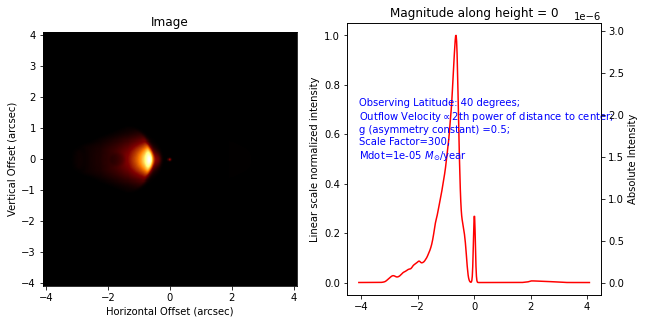

In [29]:
# 24 Plotting the Convoluted Image
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121, aspect=1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X,Y,astropy_conv,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')
# plt.annotate('*', xy=(-0.080,-0.205), color = 'green', size = 20, label = 'star')
#ax.scatter(np.array([0]),np.array([0]),color = 'green', marker = 'x')
# fig, ax = plt.subplots()
# CS = ax.contour(X,Y,logFullValues)
# plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize,angularSize,resolution+1)
y_array = astropy_conv[int(resolution/2)]
normalizedYArray = y_array/np.max(np.nan_to_num(np.array(y_array, dtype=float)))
ax2.plot(x_array,normalizedYArray, color = 'red')
x_pos = (1+np.min(normalizedYArray))/2
ax2.set_ylabel("Linear scale normalized intensity")
plt.title("Magnitude along height = 0")

plt.annotate("Observing Latitude: "+str(observingLatitudeDegrees)+" degrees;\nOutflow Velocity"+r'$\propto$'+str(power)+"th power of distance to center;\n"+"g (asymmetry constant) ="+str(asymmetry_constant)+";\nScale Factor="+str(scale_factor)+";\nMdot="+str(Mdot_Solar_Mass)+" "+'$ M_{\odot}$'+"/year", xy=(-angularSize,x_pos), color = 'blue')

ax3=ax2.twinx()
ax3.plot(x_array,np.nan_to_num(np.array(y_array, dtype=float)), color = 'blue', alpha = 0)
ax3.set_ylabel("Absolute Intensity")

plt.show()

In [30]:
# 25 Saving Convoluted Files
hdul = fits.PrimaryHDU(data=astropy_conv)
string = "Images/"+m_string+"/"+t_string+"_power_"+str(power)+"_multiplier_"+str(scale_factor)+"_convolved.fits"
hdul.writeto(string)

In [31]:
# END